# Financial fraud detection and handling imbalanced data
The main goal of this project is building a machine learning model for predicting financial fraud using [this synthetic financial fraud dataset from Kaggle](https://www.kaggle.com/ntnu-testimon/paysim1). In order to effectively do this, however, I want to first attempt to find a solution for handling severely imbalanced data in machine learning classification models. Financial fraud data is typically very imbalance, as a very low proportion of transactions are actually fraudulent, and this project aims at exploring different strategies for handling this imbalance and employing these strategies in building classification models.

In [1]:
!pip3 install imblearn
!pip3 install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from xgboost import XGBClassifier, plot_importance

In [3]:
df = pd.read_csv('transactions.csv')

In [4]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Exploratory data analysis (EDA)

### Number and ratio of fraudulent transactions in the dataset

In [7]:
n_fraud = df[df['isFraud'] == 1].shape[0]
n_non_fraud = df[df['isFraud'] == 0].shape[0]
print("Number of fraudulent transactions: ", n_fraud)
print("Number of non-fraudulent transactions: ", n_non_fraud)
print("Percentage of fraudulent transactions: ", round(n_fraud / (n_fraud + n_non_fraud) * 100, 2))

Number of fraudulent transactions:  8213
Number of non-fraudulent transactions:  6354407
Percentage of fraudulent transactions:  0.13


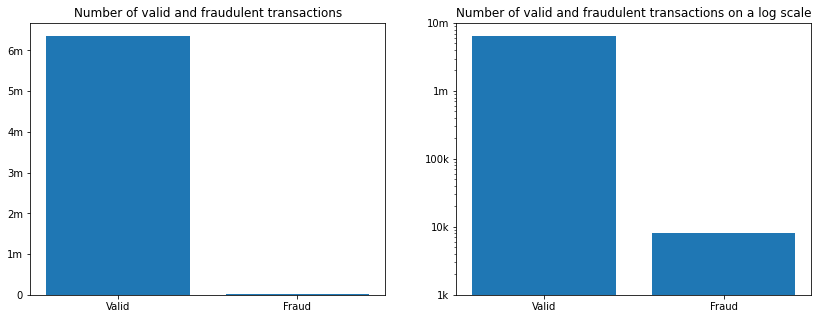

In [8]:
plt.figure(figsize=[14,5])

plt.subplot(1,2,1)
plt.bar(np.arange(2), [n_non_fraud, n_fraud])
plt.title('Number of valid and fraudulent transactions')
plt.yticks(np.arange(0,7e6,1e6),['0','1m','2m','3m','4m','5m','6m'])
plt.xticks(np.arange(2), ['Valid', 'Fraud']);

plt.subplot(1,2,2)
plt.bar(np.arange(2), [n_non_fraud, n_fraud])
plt.title('Number of valid and fraudulent transactions on a log scale')
plt.yscale('log')
plt.yticks([1000,10000,100000,1000000,10000000],['1k','10k','100k','1m','10m'])
plt.xticks(np.arange(2), ['Valid', 'Fraud']);

As we can see, the number of fraudulent transactions in the dataset is very low, making up only 0.13% of the entire dataset. The data is heavily imbalanced, as is excepted in a financial fraud dataset. This is important to keep in mind when choosing a strategy for building and deploying a classification model.

### Fraudulent transaction by transaction type

In [9]:
print("Fraudulent transactions per transaction type:\n", df[df['isFraud'] == 1].type.value_counts(), "\n")
print("Non-fraudulent transactions per transaction type:\n", df[df['isFraud'] == 0].type.value_counts())

Fraudulent transactions per transaction type:
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64 

Non-fraudulent transactions per transaction type:
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


Fraudulent transactions only show up in two of the five transaction types, namely CASH_OUT and TRANSFER. There are no fraudulent transactions in PAYMENT, CASH_IN or DEBIT. This means I should subset the data to include only the two transaction types which contain fraudulent transactions. This is done with the assumption that, even though this dataset is a sample of a larger population, fraudulent transactions will only ever appear in these two transaction types.

In [10]:
df_new = df.copy()
df_new = df_new[(df_new['type'] == 'CASH_OUT') | (df_new['type'] == 'TRANSFER')]
df_fraud = df_new.query('isFraud == 1')
df_non_fraud = df_new.query('isFraud == 0')

### Transactions flagged as fraud
There is a column called `isFlaggedFraud`, which tells us if the transaction was flagges as fraud by a detection system. Let's look at what transactions are flagged as fraud

In [11]:
print("Number of transactions flagged as fraud: ", df_new[df_new['isFlaggedFraud'] == 1].shape[0])

Number of transactions flagged as fraud:  16


In a dataset containing more than 6 million transactions, this information is not really significant or relevant at all. I will remove this column from further analysis

In [12]:
df_new.drop('isFlaggedFraud', axis=1, inplace=True)

### Errors in account balance
There seems to be a lot of zero values in the columns `newbalanceOrig` and `newbalanceDest`. I want to take a closer look at these to see if there is an error or missing data. Logically, the new balance in the origin account should be the old balance minus the transaction amount.

In [13]:
errorbalance = ((df_new['oldbalanceOrg'] - df_new['amount'] != df_new['newbalanceOrig']) | \
                  (df_new['oldbalanceDest'] + df_new['amount'] != df_new['newbalanceDest'])).mean()
print("Percentage of transactions with errors in balance after transaction: ", round(errorbalance*100, 2))

Percentage of transactions with errors in balance after transaction:  96.08


96% of account balances after the transaction contain errors. Let's see if there is any difference in percentage for fraudulent and non-fraudulent transactions.

In [14]:
fraud_error = ((df_fraud['oldbalanceOrg'] - df_fraud['amount'] != df_fraud['newbalanceOrig']) | \
                  (df_fraud['oldbalanceDest'] + df_fraud['amount'] != df_fraud['newbalanceDest']))
nonfraud_error = ((df_non_fraud['oldbalanceOrg'] - df_non_fraud['amount'] != df_non_fraud['newbalanceOrig']) | \
                    (df_non_fraud['oldbalanceDest'] + df_non_fraud['amount'] != df_non_fraud['newbalanceDest']))
print('Percentage of balance errors in fraudulent transactions: ', round(fraud_error.mean()*100,2))
print('Percentage of balance errors in non-fraudulent transactions: ', round(nonfraud_error.mean()*100,2))

Percentage of balance errors in fraudulent transactions:  65.01
Percentage of balance errors in non-fraudulent transactions:  96.17


The percentage of balance error is actually lower in the fraudulent transactions than in the non-fraudulent transactions.

Without more in-depth knowledge about the data, it's impossible to know the cause of the error balances. I'm also hesitant to attempt any corretions in the data og remove the balance columns, as they could contain valuable information for the model to identify fraudulent transactions. I will let the original balance columns be, but I will create a new column containing the size of the "error" (assuming that the new balance should be the old balance plus/minus the amount transferred)

In [15]:
# Create columns with size of error balance
df_new['errorbalanceOrig'] = df_new.newbalanceOrig + df_new.amount - df_new.oldbalanceOrg
df_new['errorbalanceDest'] = df_new.oldbalanceDest + df_new.amount - df_new.newbalanceDest

In [16]:
df_new.errorbalanceOrig.describe()

count    2.770409e+06
mean     2.859850e+05
std      8.753230e+05
min     -1.000000e-02
25%      5.185310e+04
50%      1.435971e+05
75%      2.798912e+05
max      9.244552e+07
Name: errorbalanceOrig, dtype: float64

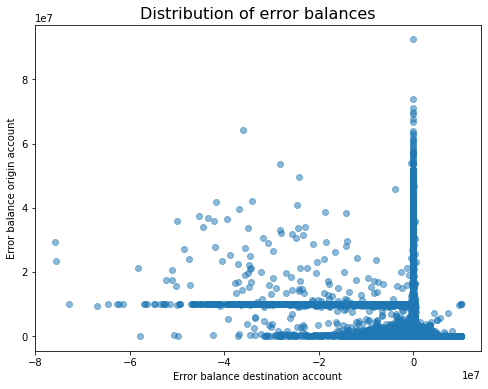

In [17]:
plt.figure(figsize=[8,6])
plt.scatter(data=df_new, x='errorbalanceDest', y='errorbalanceOrig', alpha=0.5)
plt.title('Distribution of error balances', size=16)
plt.xlabel('Error balance destination account')
plt.ylabel('Error balance origin account');

The scatter plot above tells us that most of the balance errors for the origin account are more or less exclusively positive numbers, while balance errors for the destination account is mostly negative numbers

In [18]:
fraud_errorOrig_pos = (df_new.query('isFraud == 1')['errorbalanceOrig']>0).sum() / (df_new.query('isFraud == 1')['errorbalanceOrig']!=0).sum()
fraud_errorDest_pos = (df_new.query('isFraud == 1')['errorbalanceDest']>0).sum() / (df_new.query('isFraud == 1')['errorbalanceDest']!=0).sum()
nonfraud_errorOrig_pos = (df_new.query('isFraud == 0')['errorbalanceOrig']>0).sum() / (df_new.query('isFraud == 0')['errorbalanceOrig']!=0).sum()
nonfraud_errorDest_pos = (df_new.query('isFraud == 0')['errorbalanceDest']>0).sum() / (df_new.query('isFraud == 0')['errorbalanceDest']!=0).sum()

print('Proportion of fraudulent errorbalanceOrig >0: ', round(fraud_errorOrig_pos,2))
print('Proportion of non-fraudulent errorbalanceOrig >0: ', round(nonfraud_errorOrig_pos,2),'\n')
print('Proportion of fraudulent errorbalanceDest >0: ', round(fraud_errorDest_pos,2))
print('Proportion of non-fraudulent errorbalanceDest >0: ', round(nonfraud_errorDest_pos,2))

Proportion of fraudulent errorbalanceOrig >0:  0.91
Proportion of non-fraudulent errorbalanceOrig >0:  0.99 

Proportion of fraudulent errorbalanceDest >0:  0.88
Proportion of non-fraudulent errorbalanceDest >0:  0.47


It's interesting to note that error balances in the origin account is a bit more likely to be positive in non-fraudulent transactions. As for error balances in the destination account, they are much more likely to be positive in fraudulent transactions. This could make the errorbalance features useful features for the classification model.

In [19]:
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,errorbalanceOrig,errorbalanceDest
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0.00,181.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0.00,21363.0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,213808.94,182703.5
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,214605.30,237735.3
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,300850.89,-2401220.0


### Transactions by time step
The `step` feature in the dataset gives a timeline to the data. Each step is one hour and the total of 743 steps represent one month of transactions (30 days). Let's see if there is anything in particular about the distribution of transactions throughout the month.

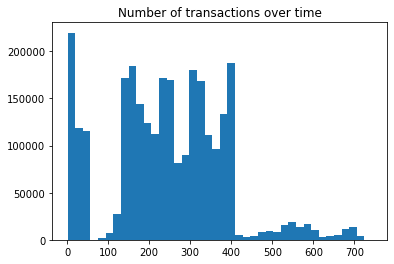

In [20]:
plt.hist(df_new.step, bins=40)
plt.title('Number of transactions over time');

The distribution of transactions over time is quite uneven. There is an initial peak of transactions for the first 50-60 hours or so, and then a break before most of the transactions happen between about the 120-400 hour time step. Let's see if there is any difference between fraudulent and non-fraudulent transactions

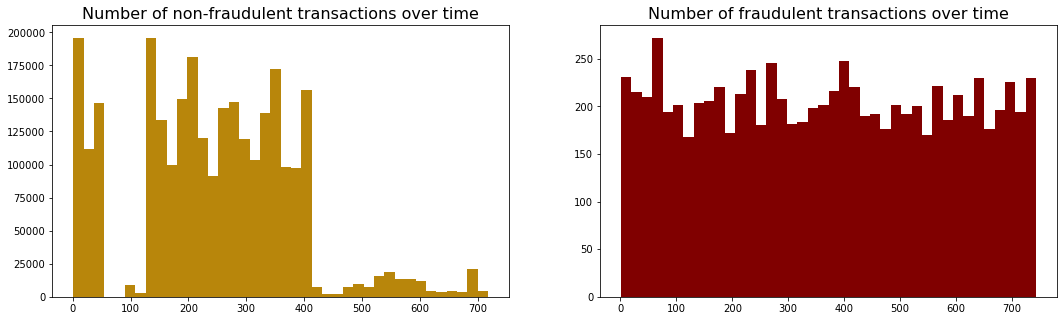

In [21]:
plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
plt.hist(df_new.query('isFraud == 0')['step'], bins=40, color='darkgoldenrod')
plt.title('Number of non-fraudulent transactions over time', size=16);

plt.subplot(1,2,2)
plt.hist(df_new.query('isFraud == 1')['step'], bins=40, color='maroon')
plt.title('Number of fraudulent transactions over time', size=16);

As we can see, the distributions of transactions over time is markedly different between fraudulent and non-fraudulent transactions. Fraudulent transactions are happening at a more or less unchanged rate regardless of time, while non-fraudulent transactions have a very uneven distribution. This could make the `step` feature useful for modelling. I'd like to break it down a bit and look at transactions throughout the day, ie. during a 24 hour period.

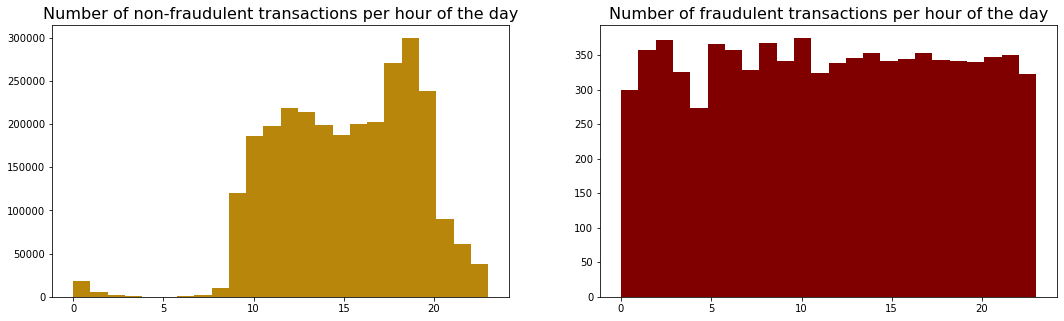

In [22]:
plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
plt.hist((df_new.query('isFraud == 0')['step']) % 24, bins=24, color='darkgoldenrod')
plt.title('Number of non-fraudulent transactions per hour of the day', size=16);

plt.subplot(1,2,2)
plt.hist((df_new.query('isFraud == 1')['step']) % 24, bins=24, color='maroon')
plt.title('Number of fraudulent transactions per hour of the day', size=16);

It's important to note that I don't have any information about what the initial timestep is, so the first timestep is not necessarily the first hour of the first day (ie. 00:00 to 01:00), but looking at the distribution of non-fraudulent transactions, it seems to be a likely theory, with few transactions happening the first few hours (assuming this is the night time), and most of the transactions happening between time step 9 to 24.

The distribution of fraudulent transactions is again very different from the non-fraudulent. They are evenly distributed throughout the day. This could be very useful information and I will therefore create a new feature in the data for hour of day.

In [23]:
# Create new column containing the hour of the day
df_new['step_24h'] = df_new.step % 24

### Account names
Each transaction has an account name for the origin account and the destination account. For these features to be of further interest, there should be account names that show up multiple times in the fraudulent transactions.

In [24]:
print('Maximum number of appearances of account name in nameOrig: ', df_new.query('isFraud == 1').nameOrig.value_counts().nlargest(1).sum(),'\n')
print('Maximum number of appearances of account name in nameDest: ', df_new.query('isFraud == 1').nameDest.value_counts().nlargest(1).sum())
print('Number of multiple appearances: ', ((df_new.query('isFraud == 1').nameDest.value_counts().values) > 1).sum())

Maximum number of appearances of account name in nameOrig:  1 

Maximum number of appearances of account name in nameDest:  2
Number of multiple appearances:  44


All origin account names are unique in the fraudulent transactions. In the destination account names, 44 accounts show up twice, out of more than 8000 fraudulent transactions. After seeing these results, I don't think these features will give me any interesting information, and I will drop the columns from the dataset.

In [25]:
df_new.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

## Preprocessing data for modeling

### Dummy categorical variable
I'm left with one categorical variable in the dataset. This should be dummied out. Using the pandas get_dummies function I will replace the `type` column with new columns encoded with 0 or 1 for each transaction type.

In [26]:
df_new = pd.get_dummies(df_new, prefix=['type'])

### Splitting to train and test data and scaling features
The dataset must be split into training and test data before building a model. I also want to normalize the features using a scaler. This well normalize all the features into values between 0 and 1. Machine learning algorithms tend to perform better with normalized features.

In [27]:
# Set a random state to be able to reproduce results
RandomState=5

# Split dataset into features and response value
X = df_new.drop('isFraud', axis=1)
y = df_new.isFraud

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RandomState)

# Instantiate scaler
scaler = StandardScaler()

# Fit the scaler on training data
scaler.fit(X_train)

# Transform the training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Handling imbalanced data
This dataset is, as financial fraud datasets typically are, very imbalanced. Only a small fraction of the transactions are in fact fraudulent. This can present a problem when using machine learning classification algorithms. As most cases are not fraudulent, the algorithm will be nearly 100% accurate if it simply classifies all transactions as non-fraudulent. We need to have a strategy for handling this imbalance in the data. I want to try three different strategies.

1. Use an oversampling method to increase the number of fraudulent transactions in the training data.
2. Use an undersampling method to decrease the number of non-fraudulent transactions in the training data.
3. Use class weights in the machine learning algorithm without changing the training data beforehand.

#### Oversampling
The first strategy is oversampling. I will be using Synthetic Minority Over-sampling (SMOTE) from the imbalanced learn python package. SMOTE creates synthetic data based on the existing data points in the minority class. This upsampling creates a balanced dataset with equal number of observations from both classes by increasing the number of observations with the minority class until it reaches the same number as the majority class. 

The downside of using this method is that you are essentially generating "fake" data, and it can only create data within the "bounds" of the existing data it can give your data variables lower variance than they actually have.

In [28]:
# Create upsampled data using SMOTE
X_train_upsample, y_train_upsample = SMOTE(random_state=RandomState).fit_resample(X_train, y_train)

In [29]:
y_train_upsample.value_counts()

0    2071694
1    2071694
Name: isFraud, dtype: int64

#### Undersampling
Undersampling, as the name implies, does the opposite of oversampling. It reduces the number of observations in the majority class until it reaches the same number as the minority class. The downside to using this method is that you are removing a lot of data, which gives the algorithm a lot less information to work with. It's possible some of the removed data contains important information.

In [30]:
from imblearn.under_sampling import RandomUnderSampler

In [31]:
# Create downsampled data
X_train_downsample, y_train_downsample = RandomUnderSampler(random_state=RandomState).fit_resample(X_train, y_train)

In [32]:
y_train_downsample.value_counts()

0    6112
1    6112
Name: isFraud, dtype: int64

## Modeling
It's time to start building and fitting models using the three different sets of training data created above. I will be using the XGBoost (Extreme Gradient Boosting Trees). It usually performs well with imbalanced data and is relatively fast when fitting the model, which could be important when using a large dataset like this.

#### Evaluation metrics
The first metric I will use for evaluating the results is the AUC (area under the ROC curve) score. This score indicates how well the model identifies samples as the correct class. The score gives a value between 0 and 1. 1 is the ideal score, and means that the model perfectly identifies the correct class. A score of 0.5 means that the model is completely unable to distinguish between the classes, and a score of 0 means that the model consistently classifies samples in the wrong class (ie. a complete reversal of a score of 1).

The second evaluation metric I will use is the confusion matrix. The confusion matrix shows a grid of true negatives, false positives (type I error), false negatives (type II error) and true positives. Normally, type I errors would be considered the most serious type of error. The commonly used example is in the judicial process, where the most grave error would be to wrongly convict an innocent person (ie. a false positive). However, I would argue that in this specific field, the most important thing would be to prevent fraudulent transactions being flagged as valid (ie. a false negative or a type II error). This needs to be balanced with a reasonable number of false positives, as they create unnecessary work for the financial institution and inconveniences customers.

#### Parameters
I did some experimentation with different parameters for the XGBoost algorithm. For learning rate, I ended up setting 0.1. A lower learning rate can make the model more robust for preventing overfitting. The max_depth parameter sets the maximum depth of the trees. The deeper the tree, the more prone to overfitting. Gamma is also a parameter for controlling model complexity and reducing overfitting, and sets minimum loss reduction required to make further splits.

The runtime for fitting the models was also considered when tuning parameters. For the oversampled data, the model takes a long time to fit on the data, so this was a consideration when controlling the complexity of the model.

### Model with oversampled data

In [33]:
# Instatiate model
model_oversamp = XGBClassifier(learning_rate=0.1, max_depth=5, gamma=0.3, use_label_encoder=False, verbosity=0, random_state=RandomState)

# Fit model to the training data
model_oversamp.fit(X_train_upsample, y_train_upsample)

# Predict on test data
pred_oversamp = model_oversamp.predict(X_test)

In [34]:
# Display metrics
print("Area under curve (AUC) score:\n", roc_auc_score(y_test, pred_oversamp), '\n')
print("Confusion matrix:\n", confusion_matrix(y_test, pred_oversamp))

Area under curve (AUC) score:
 0.9987811259985563 

Confusion matrix:
 [[690462     40]
 [     5   2096]]


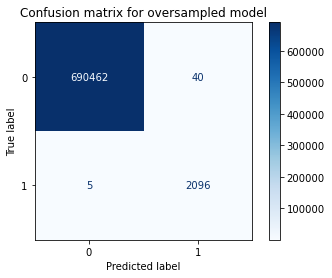

In [35]:
plot_confusion_matrix(model_oversamp, X_test, y_test, cmap='Blues')
plt.title('Confusion matrix for oversampled model');

The model using oversampled data returns excellent results. The AUC score is very close to 1. More importantly, since we're trying to detect fraudulent transactions, we should look at the actual numbers of false positives and false negatives. 

The worst outcome of the prediction is false negatives, ie. fraudulent transactions that are classified as non-fraudulent, causing us to miss cases of fraud. A low number such as 5 false negatives is very encouraging.

We would also like to minimize the false positives, ie. non-fraudulent transactions being flagged as fraudulent, as they result in unnecessary manual work in verifying the transaction as well as inconvenience for customers. A number of 40 is also quite low.

### Model with undersampled data

In [36]:
# Instantiate model
model_undersamp = XGBClassifier(learning_rate=0.1, max_depth=5, gamma=0.3, use_label_encoder=False, verbosity=0, random_state=RandomState)

# Fit model to the training data
model_undersamp.fit(X_train_downsample, y_train_downsample)

# Predict on the test data
pred_undersamp = model_undersamp.predict(X_test)

In [37]:
# Display metrics
print("Area under curve (AUC) score:\n", roc_auc_score(y_test, pred_undersamp), '\n')
print("Confusion matrix:\n", confusion_matrix(y_test, pred_undersamp))

Area under curve (AUC) score:
 0.9991245775371441 

Confusion matrix:
 [[690279    223]
 [     3   2098]]


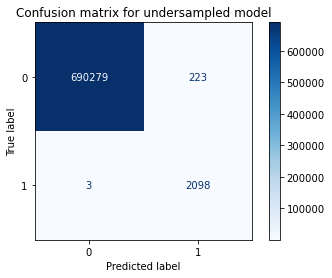

In [38]:
plot_confusion_matrix(model_undersamp, X_test, y_test, cmap='Blues')
plt.title('Confusion matrix for undersampled model');

The model using undersampled data also performs quite well. It actually has an even higher AUC score than the oversampled model. It performs even better in terms of false negatives, with only 3, but it performs worse on the false positives. It's possible that removing so much data during the undersampling process has caused the model to be worse at identifying non-fraudulent transactions. Even though the performance on false negatives is excellent, I would argue that flagging so many false positives would be too high a price.

### Model with weighted algorithm

In [39]:
# Calculate weights for the classes to use in the algorithm
weights = (y == 0).sum() / (1.0 * (y == 1).sum())

# Instantiate the model
model_weighted = XGBClassifier(learning_rate=0.1, max_depth=3, gamma=0.3, scale_pos_weight=weights, use_label_encoder=False, verbosity=0, random_state=RandomState)

# Fit model to the training data
model_weighted.fit(X_train, y_train)

# Predict on the test data
pred_weighted = model_weighted.predict(X_test)

In [40]:
# Display metrics
print("Area under curve (AUC) score:\n", roc_auc_score(y_test, pred_weighted), '\n')
print("Confusion matrix:\n", confusion_matrix(y_test, pred_weighted))

Area under curve (AUC) score:
 0.9989010778410549 

Confusion matrix:
 [[690299    203]
 [     4   2097]]


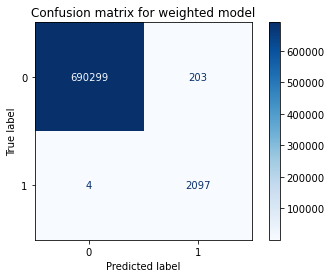

In [41]:
plot_confusion_matrix(model_weighted, X_test, y_test, cmap='Blues')
plt.title('Confusion matrix for weighted model');

The performance of the model using class weights in the algorithm is quite similar to the undersampled model. AUC score is excellent, as well as false negative performance, but the number of false positives is again a bit high.

## Conclusion
All the models performed very well in terms of AUC score and false negatives, but the oversampled model was superior in terms of false positives. 

In financial fraud prediction, what you absolutely want to avoid is classifying a fraudulent transaction as a non-fraudulent transaction. As all models performed well on this metric, they all pass the most important test. However, the amount of false positives generated by the undersampled and the weighted models would present a problem in terms of unnecessary manual verification work for the financial institution as well as a large inconvenience for customers who would possible have their accounts or credit cards blocked while the transaction is verified. Financially, the cost of handling false positives could exceed the cost of a few extra false negatives.

For this experiment, the oversampling strategy was the most effective. Oversampling the data, thereby generating more data for the model to learn from, seems to have enabled the model to more effectively identify true negatives and avoid false positives. The undersampled model, however, has removed millions of rows and possibly lost out on some useful information. It still performed very well on false negatives, even better than oversampling, but considerable worse on false positives. The weighted model performed similarly to the undersampled model. This suggests that the oversampling served to enrich the data and enabled better performance from the algorithm.